In [5]:
import torch
import numpy as np
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding, FCEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

2025-04-22 16:03:40.796640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745330620.808129   10713 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745330620.812019   10713 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745330620.821062   10713 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745330620.821077   10713 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745330620.821078   10713 computation_placer.cc:177] computation placer alr

In [6]:
ts, dt = (30.0, 0.1)

In [7]:
def amv_simulator(theta):
    m, Iz, xg, Xud, Yvd, Yrd, Nvd, Nrd, Xu, Xuu, Yv, Yvv, Yr, Nv, Nr, Nrr = theta
    m11 = m - Xud
    m22 = m - Yvd
    m23 = m * xg - Yrd
    m32 = m * xg - Nvd
    m33 = Iz - Nrd
    mt = m22*m33-m23*m32

    M = np.array([[m11, 0, 0], [0, m22, m23], [0, m32, m33]])
    B = dt * np.linalg.inv(M)
    
    a1 = dt * (m - Yvd) / (m - Xud)
    a2 = dt * (m * xg - Yrd) / (m - Xud)
    a3 = (-dt * (Iz - Nrd) * (m - Xud) / mt) + (dt * (m * xg - Yrd) * (m * xg - Yrd) / mt)
    a4 = dt * (m * xg - Yrd) * (Xud - Yvd) / mt
    a5 = (dt * (m * xg - Nvd) * (m - Xud) / mt) - (dt * (m - Yvd) * (m * xg - Yrd) / mt)
    a6 = -dt * (m - Yvd) * (Xud - Yvd) / mt

    b1  = dt * Xu / (m - Xud)
    b2  = dt * Xuu / (m - Xud)
    b3  = (dt * (Iz - Nrd) * Yv / mt) - (dt * (m * xg - Yrd) * Nv / mt)
    b4  = (dt * (Iz - Nrd) * Yr / mt) - (dt * (m * xg - Yrd) * Nr / mt)
    b5  = dt * (Iz - Nrd) * Yvv / mt
    b6  = -dt * (m * xg - Yrd) * Nrr / mt
    b7  = (dt * (m - Yvd) * Nv / mt) - (dt * (m * xg - Nvd) * Yv / mt)
    b8  = (dt * (m - Yvd) * Nr / mt) - (dt * (m * xg - Nvd) * Yr / mt)
    b9  = -dt * (m * xg - Nvd) * Yvv / mt
    b10 = dt * (m - Yvd) * Nrr / mt

    tau = np.array([5, 10, 0]).reshape(3,1)

    steps = int(ts/dt)
    u0 = 0.0
    v0 = 0.0
    r0 = 0.0

    u, v, r = float(u0), float(v0), float(r0)

    uvr = np.array([[u, v, r]])

    trajectory = []

    for _ in range(steps):

        c = np.array([[a1*v*r + a2*r*r + b1*u + b2*abs(u)*u],
                      [a3*u*r + a4*u*v + b3*v + b4*r + b5*abs(v)*v + b6*abs(r)*r],
                      [a5*u*r + a6*u*v + b7*v + b8*r + b9*abs(v)*v + b10*abs(r)*r]])
        
        uvr = uvr + c.T + (B @ tau).T

        u, v, r = uvr.flatten()

        trajectory.append(uvr.flatten())

    return torch.tensor(trajectory)

In [8]:
# True parameters
m_true   = 23.8
Iz_true   = 1.76
xg_true   = 0.046

Xud_true  = -2
Yvd_true  = -10
Yrd_true  = 0
Nvd_true  = 0
Nrd_true  = -1

Xu_true   = -0.7225
Xuu_true  = -1.3274
Yv_true   = -0.8612
Yvv_true  = -36.2823
Yr_true   = 0.1079
Nv_true   = 0.1052
Nr_true  = -0.5
Nrr_true = -1

true_params = torch.tensor([m_true, Iz_true, xg_true, Xud_true, Yvd_true, Yrd_true, Nvd_true, Nrd_true, Xu_true, Xuu_true, Yv_true, Yvv_true, Yr_true, Nv_true, Nr_true, Nrr_true])

In [9]:
x_obs = amv_simulator(true_params).numpy()

/tmp/ipykernel_10713/1130820154.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(trajectory)


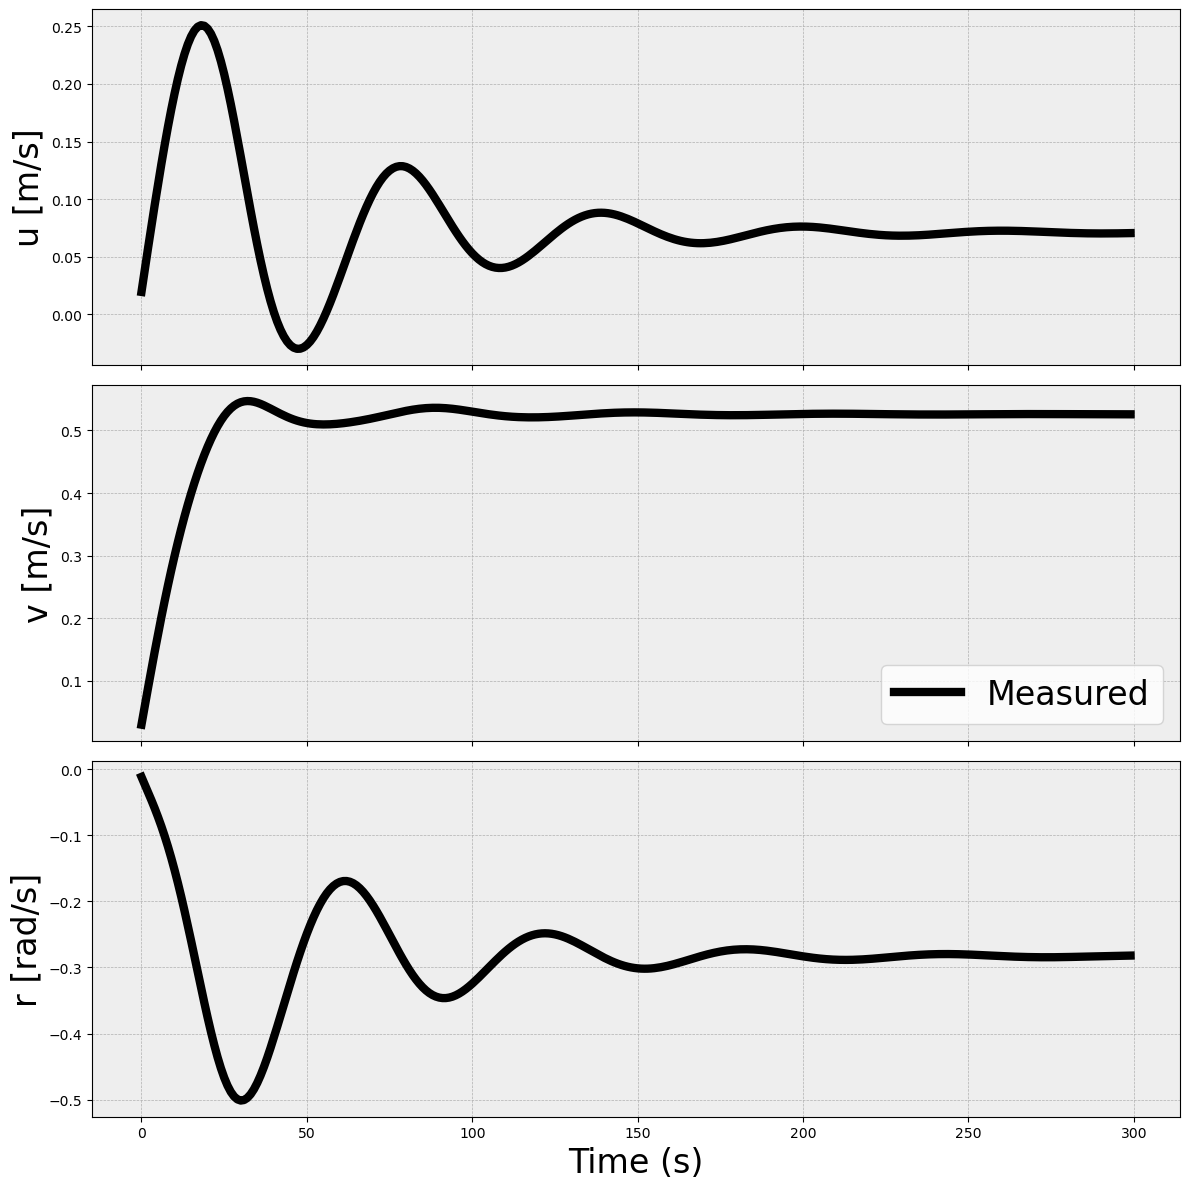

In [10]:
t = torch.arange(x_obs.shape[0])

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define colors
bg_color = '#EEEEEE'
line_width = 6
font_size = 24

# Subplot 1: u [m/s]
axes[0].plot(t, x_obs[:, 0], '-k', linewidth=line_width, label='Measured')
axes[0].set_ylabel('u [m/s]', fontsize=font_size)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_facecolor(bg_color)

# Subplot 2: v [m/s]
axes[1].plot(t, x_obs[:, 1], '-k', linewidth=line_width, label='Measured')
axes[1].set_ylabel('v [m/s]', fontsize=font_size)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].set_facecolor(bg_color)
axes[1].legend(fontsize=font_size)

# Subplot 3: r [rad/s]
axes[2].plot(t, x_obs[:, 2], '-k', linewidth=line_width, label='Measured')
axes[2].set_ylabel('r [rad/s]', fontsize=font_size)
axes[2].set_xlabel('Time (s)', fontsize=font_size)
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[2].set_facecolor(bg_color)

# Apply general figure settings
plt.tight_layout()
plt.show()


In [7]:
dim = int(ts/dt) * 3
# embedding_net = FCEmbedding(
#     input_dim=dim,
#     num_hiddens=3
# )

embedding_net = CNNEmbedding(
    input_shape=(dim, ), 
    output_dim=16,
    # out_channels_per_layer=[64, 128, 256],
    # num_conv_layers=3,
    # num_linear_layers=3,
    # num_linear_units=200,
)

In [8]:
prior = BoxUniform(
    low=torch.tensor([20.0, 1.0, 0.0, -5.0, -15.0, -5.0, -5.0, -5.0, -1.0, -2.0, -1.0, -40.0, -1.0, -1.0, -1.0, -2.0]),
    high=torch.tensor([30.0, 3.0, 0.1, 0.0, -5.0, 5.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0])
)
prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [9]:
simulator_wrapper = process_simulator(amv_simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [10]:
neural_posterior = posterior_nn(model='maf', embedding_net=embedding_net)

In [11]:
inference = NPE(prior=prior, density_estimator=neural_posterior)

In [12]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_39721/3978408597.py:50: RuntimeWarning: invalid value encountered in add
  uvr = uvr + c.T + (B @ tau).T


In [13]:
density_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 333 epochs.

In [14]:
posterior = inference.build_posterior(density_estimator)

In [15]:
samples = posterior.sample((5000,), x=x_obs)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

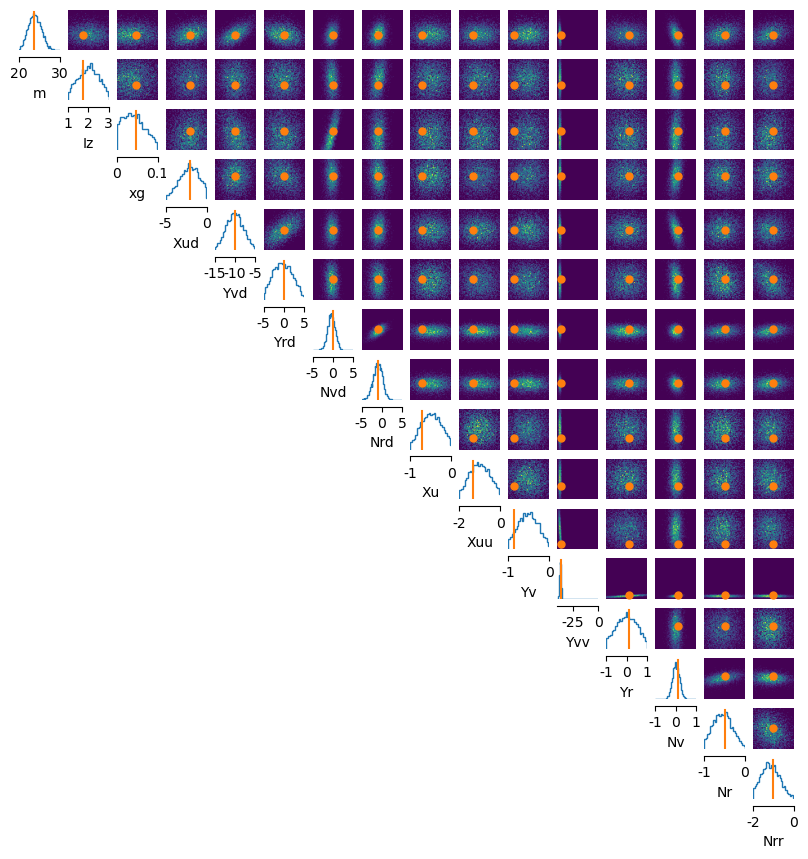

In [16]:
fig, ax = analysis.pairplot(
    samples,
    points=true_params.unsqueeze(0),
    labels=['m', 'Iz', 'xg', 'Xud', 'Yvd', 'Yrd', 'Nvd', 'Nrd', 'Xu', 'Xuu', 'Yv', 'Yvv', 'Yr', 'Nv', 'Nr', 'Nrr'],
    limits=[[20, 30], [1, 3], [0, 0.1], [-5, 0], [-15, -5], [-5, 5], [-5, 5], [-5, 5], [-1, 0], [-2, 0], [-1, 0], [-40, 0], [-1, 1], [-1, 1], [-1, 0], [-2, 0]],
)

In [17]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=x_obs).numpy()
posterior_min = np.array([[20, 1, 0, -5, -15, -5, -5, -5, -1, -2, -1, -40, -1, -1, -1, -2]])
posterior_max = np.array([[30, 3, 0.1, 0, 0, 5, 5, 5, 0, 0, 0, 0, 1, 1, 0, 0]])
x_min = amv_simulator(posterior_min.squeeze())
x_max = amv_simulator(posterior_max.squeeze())
x_posterior = amv_simulator(posterior_sample.squeeze())
print(posterior_sample)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

[[ 24.162323     1.1612108    0.08291846  -2.4452045  -11.700519
   -1.5652869    1.48724     -0.17540552  -0.13176633  -0.71972865
   -0.43996623 -37.121        0.24389361  -0.11481063  -0.7872993
   -0.7357167 ]]


/tmp/ipykernel_39721/3978408597.py:46: RuntimeWarning: overflow encountered in scalar multiply
  c = np.array([[a1*v*r + a2*r*r + b2*abs(u)*u],
/tmp/ipykernel_39721/3978408597.py:46: RuntimeWarning: invalid value encountered in scalar add
  c = np.array([[a1*v*r + a2*r*r + b2*abs(u)*u],
/tmp/ipykernel_39721/3978408597.py:47: RuntimeWarning: overflow encountered in scalar multiply
  [a3*u*r + a4*u*v + b3*v + b4*r + b5*abs(v)*v + b6*abs(r)*r],
/tmp/ipykernel_39721/3978408597.py:47: RuntimeWarning: invalid value encountered in scalar multiply
  [a3*u*r + a4*u*v + b3*v + b4*r + b5*abs(v)*v + b6*abs(r)*r],
/tmp/ipykernel_39721/3978408597.py:48: RuntimeWarning: invalid value encountered in scalar multiply
  [a5*u*r + a6*u*v + b7*v + b8*r + b9*abs(v)*v + b10*abs(r)*r]])


/tmp/ipykernel_39721/3325889580.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-k" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0].plot(t, x_posterior[:, 0], '-k', label="Posterior", linestyle='--', color="red")
/tmp/ipykernel_39721/3325889580.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  axes[0].plot(t, x_posterior[:, 0], '-k', label="Posterior", linestyle='--', color="red")
/tmp/ipykernel_39721/3325889580.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-k" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1].plot(t, x_posterior[:, 1], '-k', label="Posterior", linestyle='--', color="green")
/tmp/ipykernel_39721/3325889580.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument 

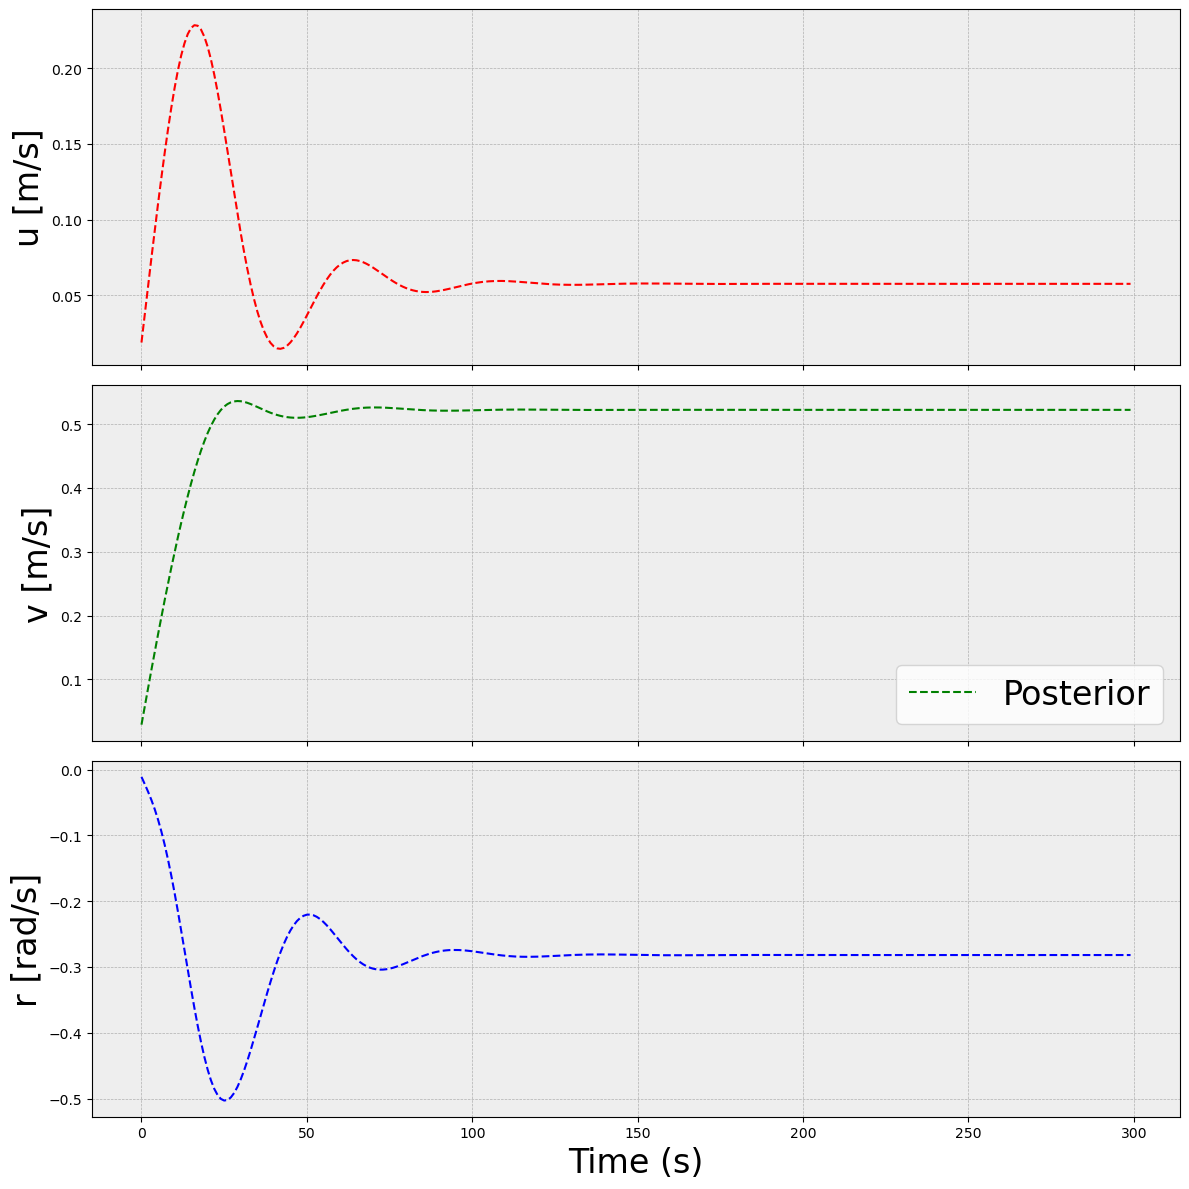

In [18]:
t = torch.arange(x_obs.shape[0])

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define colors
bg_color = '#EEEEEE'
line_width = 6
font_size = 24

# Subplot 1: u [m/s]
axes[0].plot(t, x_posterior[:, 0], '-k', label="Posterior", linestyle='--', color="red")
axes[0].set_ylabel('u [m/s]', fontsize=font_size)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_facecolor(bg_color)

# Subplot 2: v [m/s]
axes[1].plot(t, x_posterior[:, 1], '-k', label="Posterior", linestyle='--', color="green")
axes[1].set_ylabel('v [m/s]', fontsize=font_size)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].set_facecolor(bg_color)
axes[1].legend(fontsize=font_size)

# Subplot 3: r [rad/s]
axes[2].plot(t, x_posterior[:, 2], '-k', label="Posterior", linestyle='--', color="blue")
axes[2].set_ylabel('r [rad/s]', fontsize=font_size)
axes[2].set_xlabel('Time (s)', fontsize=font_size)
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[2].set_facecolor(bg_color)

# Apply general figure settings
plt.tight_layout()
plt.show()